In [124]:
import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

In [125]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

/var/folders/v4/pcb5pkfn5h7b0vj_np_0db040000gn/T/ipykernel_21827/3828322551.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [126]:
import yfinance as yf
import datetime

In [127]:
stock=['TSLA','AAPL','AMD','^GSPC']
df=pd.DataFrame()
df = yf.download(stock, start='2016-9-29', end='2021-9-29')['Close']

[*********************100%***********************]  4 of 4 completed


# Simple Moving Average (SMA)


</n>Trading Stratergy :

Go long (= +1) when the shorter SMA is above the longer SMA.

Go short (= -1) when the shorter SMA is below the longer SMA.
</n>

In [128]:
df

,AAPL,AMD,TSLA,^GSPC
Date,,,,
2016-09-29,28.045000,6.670000,13.380000,2151.129883
2016-09-30,28.262501,6.910000,13.602000,2168.270020
2016-10-03,28.129999,6.950000,14.246667,2161.199951
2016-10-04,28.250000,6.970000,14.094000,2150.489990
2016-10-05,28.262501,6.780000,13.897333,2159.729980
...,...,...,...,...
2021-09-22,145.850006,104.379997,250.646667,4395.640137
2021-09-23,146.830002,106.150002,251.213333,4448.979980
2021-09-24,146.919998,105.800003,258.130005,4455.479980


In [129]:
SMA1 = 42  
SMA2 = 252  
ticker='AMD'

In [130]:
data=df[[ticker]].copy()

In [131]:
data['SMA1'] = data[ticker].rolling(SMA1).mean()  
data['SMA2'] = data[ticker].rolling(SMA2).mean()  

<AxesSubplot: xlabel='Date'>

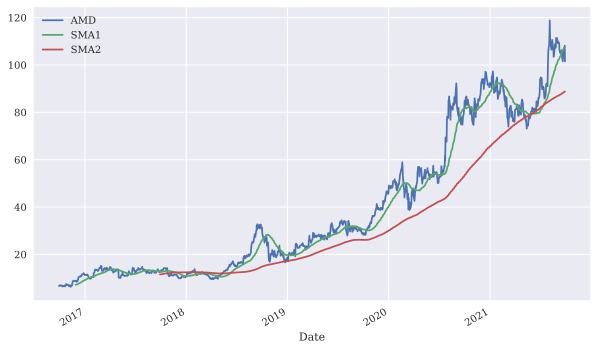

In [132]:
data.plot(figsize=(10, 6))


In [133]:
data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)  


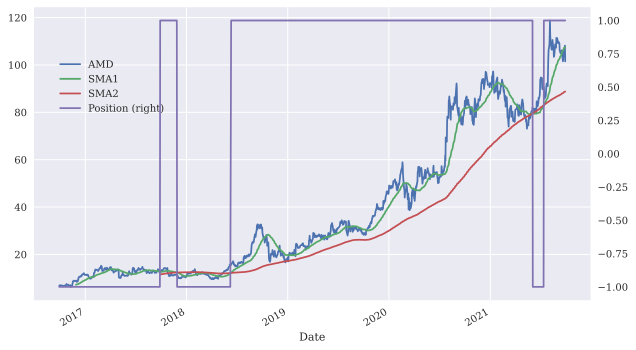

In [134]:
ax = data.plot(secondary_y='Position', figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

In [135]:
data['Returns'] = np.log(data[ticker] / data[ticker].shift(1))  
# Calculates the log returns of the stock 
# (i.e., the benchmark investment).

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [136]:
data['Strategy'] = data['Position'].shift(1) * data['Returns']  

In [137]:
data.round(4).head()

,AMD,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2016-09-29,6.67,NaN,NaN,-1,NaN,NaN
2016-09-30,6.91,NaN,NaN,-1,0.0353,-0.0353
2016-10-03,6.95,NaN,NaN,-1,0.0058,-0.0058
2016-10-04,6.97,NaN,NaN,-1,0.0029,-0.0029
2016-10-05,6.78,NaN,NaN,-1,-0.0276,0.0276


In [138]:
data.dropna(inplace=True)

In [139]:
data.round(4).head()

,AMD,SMA1,SMA2,Position,Returns,Strategy
Date,,,,,,
2017-09-28,12.74,12.7345,11.5407,1,0.0000,-0.0000
2017-09-29,12.75,12.7117,11.5648,1,0.0008,0.0008
2017-10-02,12.71,12.6960,11.5878,1,-0.0031,-0.0031
2017-10-03,13.42,12.7002,11.6135,1,0.0544,0.0544
2017-10-04,13.31,12.7048,11.6387,1,-0.0082,-0.0082


In [140]:
np.exp(data[['Returns', 'Strategy']].sum())  
#Sums up the log returns for the strategy and the benchmark 
# investment and calculates the exponential value to arrive at the 
# absolute performance.

Returns     7.968603
Strategy    3.178741
dtype: float64

In [141]:
#The stratergy clearly underperforms for Tesla 
# Moving averages draw trends from past price information only. 
# Like any type of technical analysis tool, chart indicators don't 
# take into account changes in fundamental factors that may affect a 
# stock's future performance, such as new competitors, 
# higher or lower demand for products in the industry, and changes 
# in the managerial structure of the company. 



In [142]:
data[['Returns', 'Strategy']].std() * 252 ** 0.5 
# Calculates the annualized volatility for the strategy and 
# the benchmark investment.

Returns     0.551857
Strategy    0.552526
dtype: float64

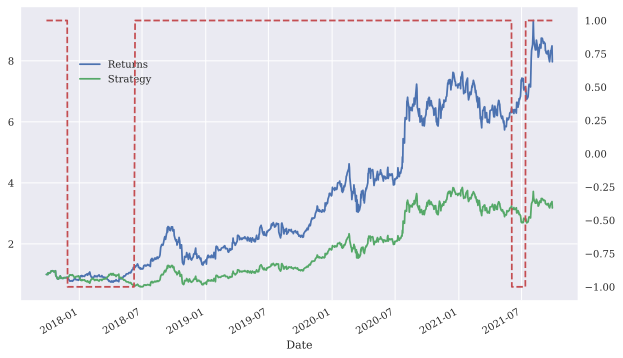

In [143]:
ax = data[['Returns', 'Strategy']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))
data['Position'].plot(ax=ax, secondary_y='Position', style='--')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));


</n>Optimization</n>

In [144]:
from itertools import product

In [145]:
sma1 = range(20, 61, 4)  
sma2 = range(180, 281, 10)  

In [146]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):  
    data = pd.DataFrame(df[ticker])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[ticker] / data[ticker].shift(1))
    data['SMA1'] = data[ticker].rolling(SMA1).mean()
    data['SMA2'] = data[ticker].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    results = results.append(pd.DataFrame(
                {'SMA1': SMA1, 'SMA2': SMA2,
                 'MARKET': perf['Returns'],
                 'STRATEGY': perf['Strategy'],
                 'OUT': perf['Strategy'] - perf['Returns']},
                 index=[0]), ignore_index=True)  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/v4/pcb5pkfn5h7b0vj_np_0db040000gn/T/ipykernel_21827/807937380.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/v4/pcb5pkfn5h7b0vj_np_0db040000gn/T/ipykernel_21827/807937380.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

In [147]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMA1      121 non-null    int64  
 1   SMA2      121 non-null    int64  
 2   MARKET    121 non-null    float64
 3   STRATEGY  121 non-null    float64
 4   OUT       121 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.9 KB


In [148]:
results.sort_values('OUT', ascending=False).head(7)

,SMA1,SMA2,MARKET,STRATEGY,OUT
20,24,270,7.124210,5.154555,-1.969655
32,28,280,8.424896,5.961938,-2.462958
19,24,260,7.410219,4.847317,-2.562902
21,24,280,8.424896,5.738932,-2.685964
31,28,270,7.124210,4.366886,-2.757324
30,28,260,7.410219,4.083006,-3.327213
42,32,270,7.124210,3.736400,-3.387810


</n>Random Walk Hypothesis</n>

In [149]:
ticker2 = '^GSPC'

In [150]:
df2=df[[ticker2]].copy()

In [151]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)  
    data[col] = data[ticker].shift(lag)  
    cols.append(col)  

In [152]:
data.head(7)

,AMD,Returns,SMA1,SMA2,Position,Strategy,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,,,,
2017-11-08,11.71,-0.028621,12.754333,11.696179,1,-0.028621,NaN,NaN,NaN,NaN,NaN
2017-11-09,11.12,-0.051698,12.729167,11.711214,1,-0.051698,11.71,NaN,NaN,NaN,NaN
2017-11-10,11.26,0.012511,12.711167,11.726607,1,0.012511,11.12,11.71,NaN,NaN,NaN
2017-11-13,11.09,-0.015213,12.689833,11.741321,1,-0.015213,11.26,11.12,11.71,NaN,NaN
2017-11-14,11.12,0.002701,12.674333,11.756821,1,0.002701,11.09,11.26,11.12,11.71,NaN
2017-11-15,11.07,-0.004507,12.656000,11.771500,1,-0.004507,11.12,11.09,11.26,11.12,11.71
2017-11-16,11.25,0.016129,12.635500,11.787571,1,0.016129,11.07,11.12,11.09,11.26,11.12


In [153]:
data.dropna(inplace=True)

In [154]:
reg = np.linalg.lstsq(data[cols], data[ticker], rcond=-1)[0]

In [155]:
reg.round(3)

array([ 0.93 ,  0.145, -0.12 ,  0.047, -0.   ])

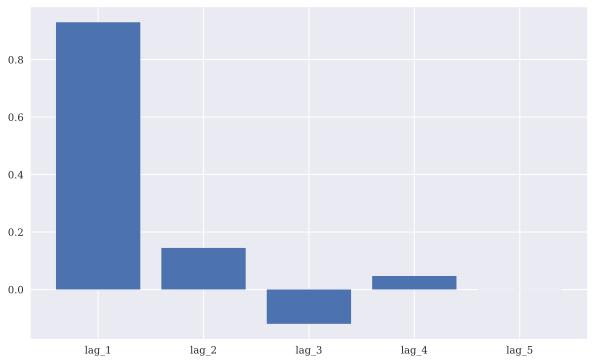

In [156]:
plt.figure(figsize=(10, 6))
plt.bar(cols, reg);


In [157]:
data['Prediction'] = np.dot(data[cols], reg)

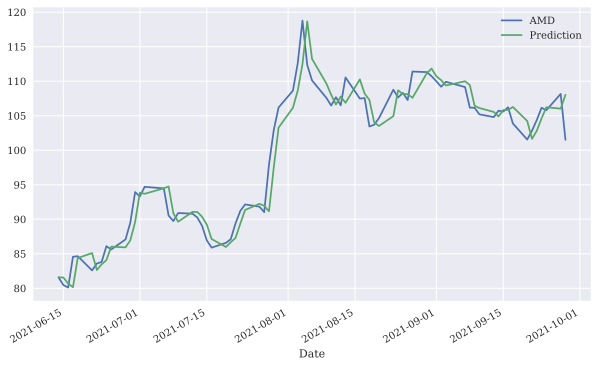

In [158]:
data[[ticker,'Prediction']].iloc[-75:].plot(figsize=(10, 6));

# Linear OLS Regression

In [159]:
# Linear OLS regression to predict the direction of market movements
# based on historical log returns. For simplicity, only two features 
# are used. The first feature (lag_1) represents the log-returns of the 
# financial time series lagged by one day. The second feature (lag_2) lags 
# the log returns by two days. Log returns—in contrast to prices—are generally stationary, 
# which is often necessary for applying statistical and ML algorithms.

In [160]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%config InlineBackend.figure_format = 'svg'

/var/folders/v4/pcb5pkfn5h7b0vj_np_0db040000gn/T/ipykernel_21827/3267769778.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [161]:
symbol='AAPL'
data = pd.DataFrame(df[symbol])
data['returns'] = np.log(data / data.shift(1))
data.dropna(inplace=True)
data['direction'] = np.sign(data['returns']).astype(int)
data.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,AAPL,returns,direction
Date,,,
2016-09-30,28.262501,0.007725,1
2016-10-03,28.129999,-0.004699,-1
2016-10-04,28.250000,0.004257,1
2016-10-05,28.262501,0.000442,1
2016-10-06,28.472500,0.007403,1


<AxesSubplot: >

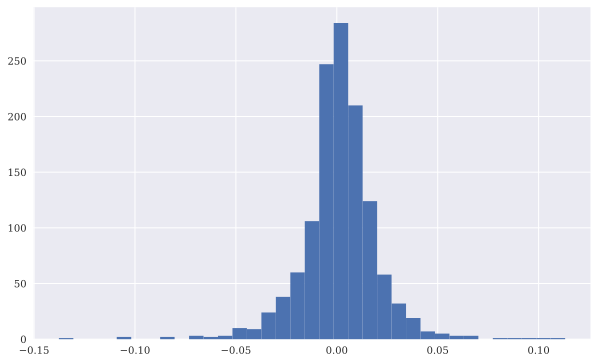

In [162]:
data['returns'].hist(bins=35, figsize=(10, 6))

In [163]:
lags = 2
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)
create_lags(data)
data.dropna(inplace=True)
data.head()

,AAPL,returns,direction,lag_1,lag_2
Date,,,,,
2016-10-04,28.250000,0.004257,1,-0.004699,0.007725
2016-10-05,28.262501,0.000442,1,0.004257,-0.004699
2016-10-06,28.472500,0.007403,1,0.000442,0.004257
2016-10-07,28.514999,0.001492,1,0.007403,0.000442
2016-10-10,29.012501,0.017297,1,0.001492,0.007403


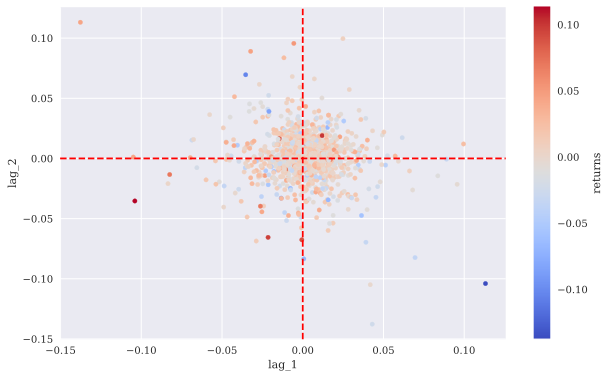

In [164]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns', 
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');

In [165]:
from sklearn.linear_model import LinearRegression  

In [166]:
# The regression is implemented on the log returns directly …
# … and on the direction data which is of primary interest.

model = LinearRegression() 

data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])  


data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])  

In [167]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(
            data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)
# The real-valued predictions are transformed to directional 
# values (+1, -1).

In [168]:
data['pos_ols_1'].value_counts() 

 1    964
-1    291
Name: pos_ols_1, dtype: int64

In [169]:
data['pos_ols_2'].value_counts()  


 1    1140
-1     115
Name: pos_ols_2, dtype: int64

In [170]:
(data['pos_ols_1'].diff() != 0).sum()  


463

In [171]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns         5.044792
strat_ols_1     4.414943
strat_ols_2    10.639068
dtype: float64

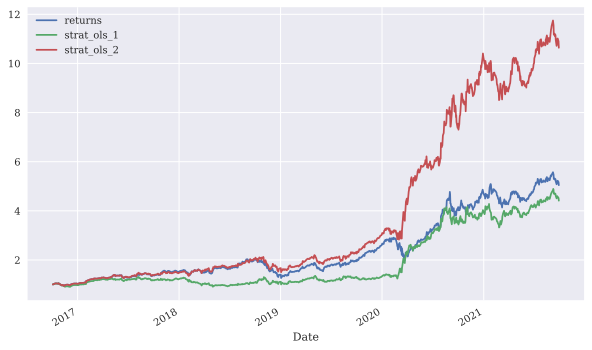

In [172]:
(data['direction'] == data['pos_ols_1']).value_counts()  
(data['direction'] == data['pos_ols_2']).value_counts()  
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

# Clustering

In [173]:
from sklearn.cluster import KMeans

In [174]:
model = KMeans(n_clusters=2, random_state=0)  
model.fit(data[cols])

KMeans(n_clusters=2, random_state=0)

In [175]:
data['pos_clus'] = model.predict(data[cols])
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)  
data['pos_clus'].values

array([ 1, -1,  1, ...,  1,  1,  1])

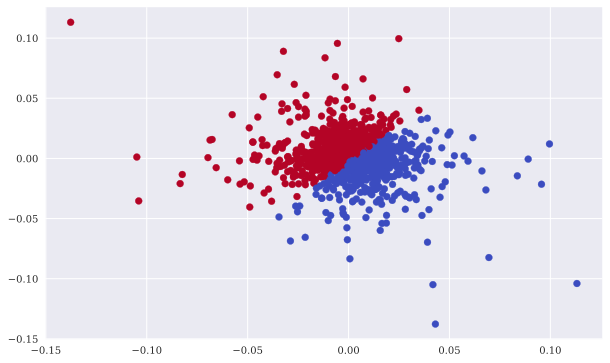

In [176]:
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],
            c=data['pos_clus'], cmap='coolwarm');

In [177]:
data['strat_clus'] = data['pos_clus'] * data['returns']
data[['returns', 'strat_clus']].sum().apply(np.exp)


returns       5.044792
strat_clus    0.972438
dtype: float64

In [178]:
(data['direction'] == data['pos_clus']).value_counts()


True     660
False    595
dtype: int64

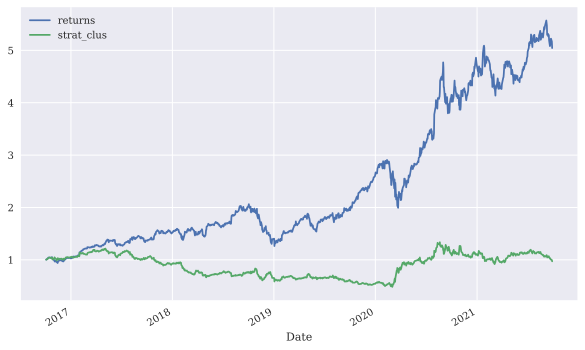

In [179]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Frequency Approach

In [180]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)


In [181]:
create_bins(data)
data[cols_bin + ['direction']].head()  

,lag_1_bin,lag_2_bin,direction
Date,,,
2016-10-04,0,1,1
2016-10-05,1,0,1
2016-10-06,1,1,1
2016-10-07,1,1,1
2016-10-10,1,1,1


In [182]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()  

lag_1_bin  lag_2_bin  direction
0          0          -1           105
                       1           145
           1          -1           146
                       0             1
                       1           176
1          0          -1           156
                       0             2
                       1           164
           1          -1           166
                       1           194
dtype: int64

In [183]:
res = grouped['direction'].size().unstack(fill_value=0)  

In [184]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]  

In [185]:
res.style.apply(highlight_max, axis=1)  


In [186]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)  

In [187]:
(data['direction'] == data['pos_freq']).value_counts()

True     651
False    604
dtype: int64

In [188]:
data['strat_freq'] = data['pos_freq'] * data['returns']
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       5.044792
strat_freq    1.914853
dtype: float64

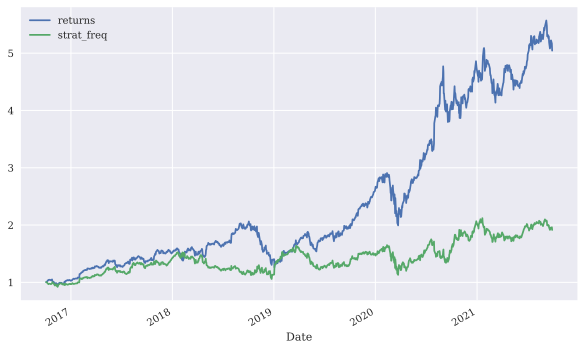

In [189]:
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Classification Algorithm 

In [190]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [191]:
C = 1
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
}

In [192]:
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction'])
            for model in models.keys()} 
    

In [193]:
fit_models(data)

In [194]:
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [195]:
derive_positions(data)

In [196]:
def evaluate_strats(data):  
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model 
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')
    

In [197]:
evaluate_strats(data)

In [198]:
sel.insert(1, 'strat_freq')

In [199]:
data[sel].sum().apply(np.exp)  

returns           5.044792
strat_freq        1.914853
strat_log_reg     5.044792
strat_gauss_nb    5.044792
strat_svm         5.044792
dtype: float64

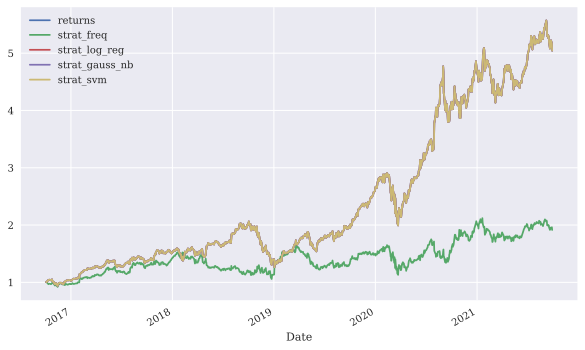

In [200]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [201]:
data = pd.DataFrame(df[symbol])


In [202]:
data['returns'] = np.log(data / data.shift(1))
data['direction'] = np.sign(data['returns'])
lags = 5  
create_lags(data)
data.dropna(inplace=True)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [203]:
create_bins(data)  
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [204]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2016-10-07,1,1,1,0,1
2016-10-10,1,1,1,1,0
2016-10-11,1,1,1,1,1
2016-10-12,1,1,1,1,1
2016-10-13,1,1,1,1,1


In [205]:
data.dropna(inplace=True)

In [206]:
fit_models(data)

In [207]:
derive_positions(data)
evaluate_strats(data)
data[sel].sum().apply(np.exp)

returns            4.984108
strat_log_reg      4.446964
strat_gauss_nb     1.629255
strat_svm         11.535748
dtype: float64

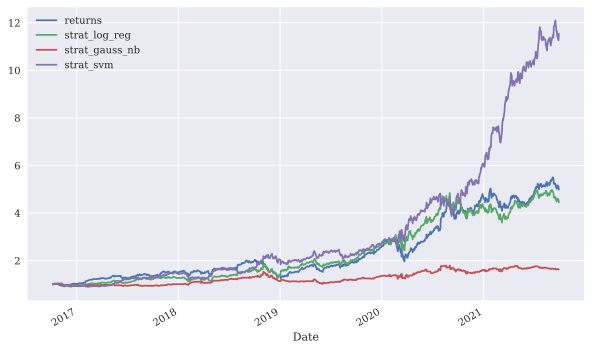

In [208]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));


In [209]:
mu = data['returns'].mean()  
v = data['returns'].std() 

In [210]:
bins = [mu - v, mu, mu + v]  
bins  

[-0.017796653978308243, 0.001282950779428971, 0.020362555537166184]

In [211]:
create_bins(data, bins)
data[cols_bin].head()


,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2016-10-07,2,1,2,1,2
2016-10-10,2,2,1,2,1
2016-10-11,2,2,2,1,2
2016-10-12,2,2,2,2,1
2016-10-13,2,2,2,2,2


In [212]:
fit_models(data)
derive_positions(data)
evaluate_strats(data)
data[sel].sum().apply(np.exp)

returns             4.984108
strat_log_reg      11.271153
strat_gauss_nb      5.431697
strat_svm         111.059782
dtype: float64

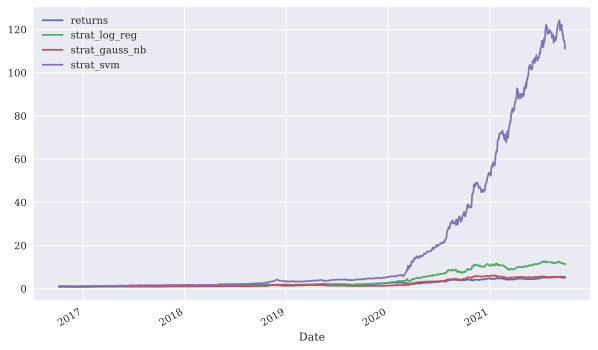

In [213]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [214]:
split = int(len(data) * 0.5)
train = data.iloc[:split].copy()
fit_models(train)  
test = data.iloc[split:].copy()  
derive_positions(test)  
evaluate_strats(test)  
test[sel].sum().apply(np.exp)

returns           2.900710
strat_log_reg     3.087298
strat_gauss_nb    2.329665
strat_svm         6.525649
dtype: float64

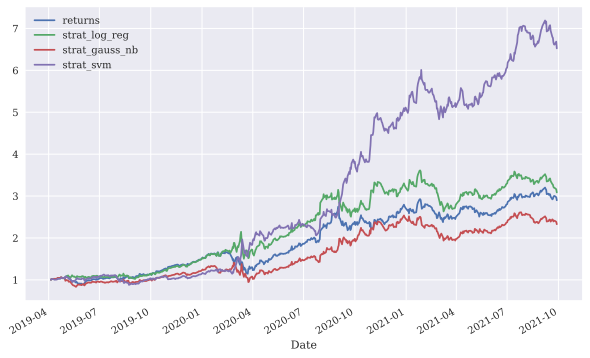

In [215]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [216]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.5,
                               shuffle=True, random_state=100)
train = train.copy().sort_index()  
train[cols_bin].head()
test = test.copy().sort_index()  
fit_models(train)
derive_positions(test)
evaluate_strats(test)
test[sel].sum().apply(np.exp)

returns           2.799856
strat_log_reg     3.022828
strat_gauss_nb    2.538186
strat_svm         1.031376
dtype: float64

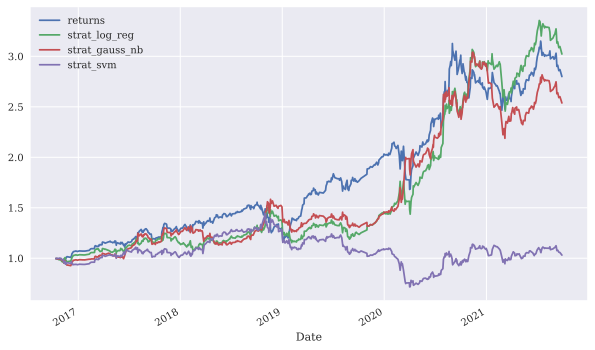

In [217]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));


# DNN with scikit-learn

In [218]:
from sklearn.neural_network import MLPClassifier


In [219]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=2 * [250], random_state=1)

In [220]:
%time model.fit(data[cols_bin], data['direction'])

CPU times: user 19.2 s, sys: 4.87 s, total: 24.1 s
Wall time: 3.99 s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [221]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [222]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns            4.984108
strat_dnn_sk    4434.266881
dtype: float64

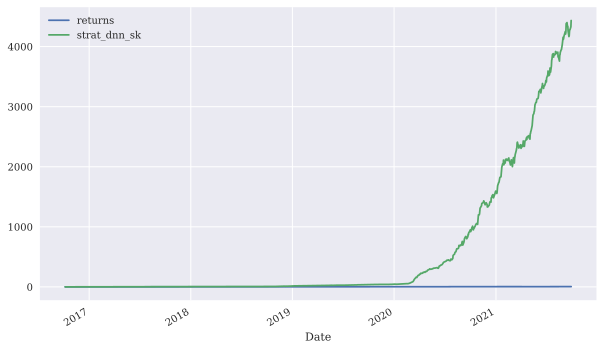

In [223]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [224]:
train, test = train_test_split(data, test_size=0.5, random_state=100)
train = train.copy().sort_index()
test = test.copy().sort_index()
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,
                     hidden_layer_sizes=3 * [500], random_state=1)  
%time model.fit(train[cols_bin], train['direction'])

CPU times: user 3min 28s, sys: 56 s, total: 4min 24s
Wall time: 45.3 s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [225]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)


returns         2.799856
strat_dnn_sk    1.669425
dtype: float64

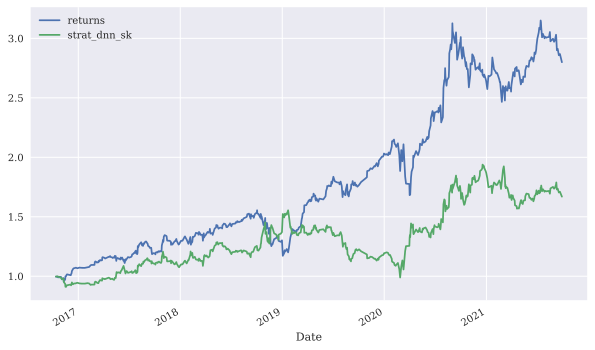

In [226]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

# DNN with Keras & TensorFlow Backend

In [227]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential


In [228]:
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=lags))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [229]:
data_ = (data - data.mean()) / data.std()
data['direction_'] = np.where(data['direction'] == 1, 1, 0)

In [230]:
model = create_model()

In [231]:
%%time
model.fit(data_[cols], data['direction_'],
          epochs=50, verbose=False)

CPU times: user 3.53 s, sys: 383 ms, total: 3.91 s
Wall time: 3.01 s


In [232]:
model.evaluate(data_[cols], data['direction_'])

40/40 [==============================] - 0s 2ms/step - loss: 0.6611 - accuracy: 0.6022


[0.6610549092292786, 0.6022364497184753]

In [233]:
pred = np.where(model.predict(data_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

40/40 [==============================] - 0s 964us/step


array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [234]:
data['pos_dnn_ke'] = np.where(pred > 0, 1, -1)  
data['strat_dnn_ke'] = data['pos_dnn_ke'] * data['returns']

In [235]:
data[['returns', 'strat_dnn_ke']].sum().apply(np.exp)


returns          4.984108
strat_dnn_ke    88.359106
dtype: float64

<AxesSubplot: xlabel='Date'>

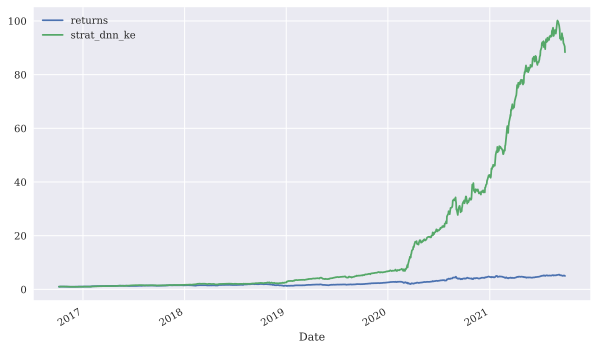

In [236]:
data[['returns', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6))

In [237]:
mu, std = train.mean(), train.std()
train_ = (train - mu) / mu.std()
model = create_model()
train['direction_'] = np.where(train['direction'] > 0, 1, 0)


In [238]:
%%time
model.fit(train_[cols], train['direction_'],
          epochs=50, verbose=False)

CPU times: user 2 s, sys: 213 ms, total: 2.21 s
Wall time: 1.74 s


In [239]:
test_ = (test - mu) / std

In [240]:
test['direction_'] = np.where(test['direction'] > 0, 1, 0)

In [241]:
model.evaluate(test_[cols], test['direction_'])

20/20 [==============================] - 0s 1ms/step - loss: 0.7807 - accuracy: 0.5527


[0.7807319760322571, 0.5527156591415405]

In [242]:
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

20/20 [==============================] - 0s 1ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [243]:
test['pos_dnn_ke'] = np.where(pred > 0, 1, -1)

In [244]:
test['strat_dnn_ke'] = test['pos_dnn_ke'] * test['returns']

In [245]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].sum().apply(np.exp)

returns         2.799856
strat_dnn_sk    1.669425
strat_dnn_ke    2.799856
dtype: float64

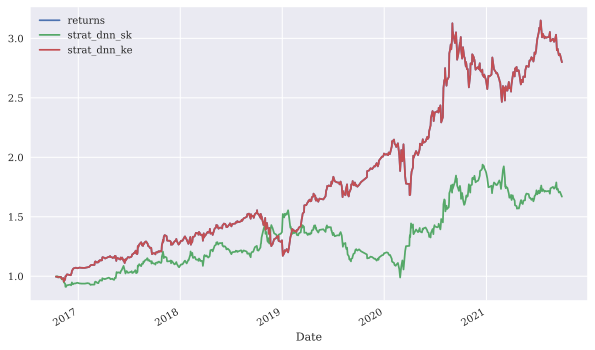

In [246]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));